In [99]:
import geopandas as gpd
import geodatasets
import matplotlib.pyplot as plt
import os
import datetime


import shapely
from shapely.geometry import Point, LineString, Polygon
import pandas as pd
import rasterio as rio
from rasterio.plot import show
import pyproj

In [100]:
file_path = '/content/'

# South Africa

,province,district,dccode,newla,hhnumber,questype,urban,addmon2,payment2,migrant,...,hoheduca,hohocp1,hohecona,hhsize,hinchh,hinchhra,hinchhse,hhinccat,peshhwei,hhid
0,Western Cape,Ceres,Breede River District Council,Ceres TLC,1,H,Urban,NaN,NaN,No migrant worker absent,...,Grade 10,N/A: Age <15 or not employed,"Unemployed, looking for work",3,R00201 - R00500,White,Female,R002401 - R006000,10.500,01 00001001 00000126 00010121 00001
1,Western Cape,Ceres,Breede River District Council,Ceres TLC,2,H,Urban,NaN,NaN,No migrant worker absent,...,Matric & Bachelor's & diploma,Secondary education teaching professiona,Employed,4,R04501 - R06000,More than 1 person,More than 1 person,R096001 - R132000,10.500,01 00001001 00000126 00010121 00002
2,Western Cape,Ceres,Breede River District Council,Ceres TLC,3,H,Urban,NaN,NaN,No migrant worker absent,...,Matric & diploma,Building finishers and related trades wo,Employed,4,R03501 - R04500,Coloured,Male,R042001 - R054000,10.500,01 00001001 00000126 00010121 00003
3,Western Cape,Ceres,Breede River District Council,Ceres TLC,4,H,Urban,NaN,NaN,No migrant worker absent,...,Grade 8,N/A: Age <15 or not employed,Not working - none of the above,1,R00501 - R01000,White,Female,R006001 - R012000,11.471,01 00001001 00000126 00010121 00004
4,Western Cape,Ceres,Breede River District Council,Ceres TLC,5,H,Urban,NaN,NaN,No migrant worker absent,...,Grade 10,N/A: Age <15 or not employed,Not working - pensioner/retired person,2,R01501 - R02500,White,Male,R018001 - R030000,10.763,01 00001001 00000126 00010121 00005
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
846473,Northern Province,Thabamoopo,Northern District Council,Zebediela RLC,1850,H,Rural,NaN,R00201 - R00500,Migrant worker absent from hhold,...,Grade 7,N/A: Age <15 or not employed,Not working - scholar/full-time student,4,NaN,More than 1 person,More than 1 person,R002401 - R006000,10.300,09 00009002 00000923 00090150 01850
846474,Northern Province,Thabamoopo,Northern District Council,Zebediela RLC,1851,H,Rural,NaN,R00201 - R00500,Migrant worker absent from hhold,...,Grade 7,N/A: Age <15 or not employed,Not working - not looking for work,7,NaN,More than 1 person,More than 1 person,R002401 - R006000,10.300,09 00009002 00000923 00090150 01851
846475,Northern Province,Thabamoopo,Northern District Council,Zebediela RLC,1852,H,Rural,NaN,NaN,No migrant worker absent,...,No schooling,N/A: Age <15 or not employed,Not working - pensioner/retired person,5,R00501 - R01000,More than 1 person,More than 1 person,R012001 - R018000,10.300,09 00009002 00000923 00090150 01852
846476,Northern Province,Thabamoopo,Northern District Council,Zebediela RLC,1853,H,Rural,NaN,NaN,No migrant worker absent,...,No schooling,Motor vehicle drivers and related worker,Employed,7,Unspecified,No person identified,No person identified,R042001 - R054000,10.300,09 00009002 00000923 00090150 01853


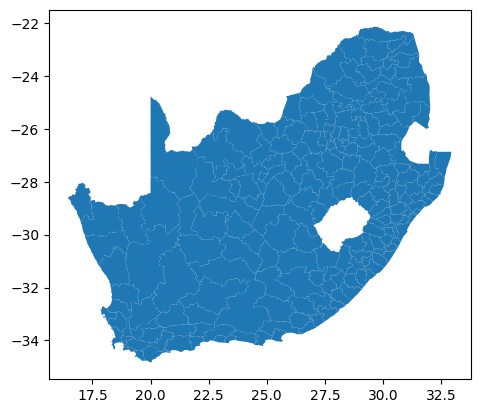

In [101]:
# Import South Africa Map
south_africa = gpd.read_file(file_path + 'South_Africa/MDB_Local_Municipal_Boundary_2018.shp')

# Load census
sa_census = pd.read_csv(file_path + 'South_Africa/census-1996-hhold-v1.2.csv', encoding = 'latin1')

south_africa.plot()
sa_census

In [102]:
dam_data = pd.read_excel(file_path + 'South_Africa/Dams_south_africa.xlsx')
dam_data

,Name of dam,Latitude deg,Lat min,Lat sec,Longitude deg,Long min,Long sec
0,NGOTWANE DAM,25.0,11.0,54.0,25.0,48.0,48.0
1,MAKGOPANE DAM,25.0,5.0,54.2,25.0,52.0,57.0
2,ROODEKOPJES DAM,25.0,24.0,24.0,27.0,34.0,39.0
3,HARTBEESPOORT DAM,25.0,43.0,32.3,27.0,50.0,54.1
4,BUFFELSPOORT DAM,25.0,46.0,49.5,27.0,29.0,14.5
...,...,...,...,...,...,...,...
10307,TSHAKHUMA DAM,23.0,1.0,58.0,30.0,16.0,55.0
10308,KORENTEPOORT DAM,34.0,0.0,17.4,21.0,9.0,56.4
10309,GRASSRIDGE DAM,31.0,46.0,4.2,25.0,27.0,57.9
10310,KNELLPOORT DAM,29.0,46.0,54.4,26.0,53.0,19.2


In [103]:
south_africa['PROVINCE'].unique()

array(['WC', 'EC', 'NC', 'KZN', 'FS', 'NW', 'MP', 'GT', 'LIM'],
      dtype=object)

In [104]:
sa_census['province'].unique()

array(['Western Cape', 'Eastern Cape', 'Northern Cape', 'Free State',
       'KwaZulu-Natal', 'North West', 'Gauteng', 'Mpumalanga',
       'Northern Province'], dtype=object)

In [105]:
population_by_province = sa_census.groupby('province')['hhsize'].sum().reset_index()
population_by_province

,province,hhsize
0,Eastern Cape,555147
1,Free State,226651
2,Gauteng,626327
3,KwaZulu-Natal,715263
4,Mpumalanga,246261
5,North West,293074
6,Northern Cape,68069
7,Northern Province,428568
8,Western Cape,349713


In [106]:
province_areas_km2 = {
    'Western Cape': 129462,
    'Eastern Cape': 168966,
    'Northern Cape': 372889,
    'Free State': 129825,
    'KwaZulu-Natal': 94361,
    'North West': 104882,
    'Gauteng': 18178,
    'Mpumalanga': 76495,
    'Northern Province': 125755
}

population_by_province['area_km2'] = population_by_province['province'].map(province_areas_km2)
population_by_province['pop_density'] = population_by_province['hhsize'] / population_by_province['area_km2']
population_by_province

,province,hhsize,area_km2,pop_density
0,Eastern Cape,555147,168966,3.285554
1,Free State,226651,129825,1.745819
2,Gauteng,626327,18178,34.455221
3,KwaZulu-Natal,715263,94361,7.580070
4,Mpumalanga,246261,76495,3.219308
5,North West,293074,104882,2.794321
6,Northern Cape,68069,372889,0.182545
7,Northern Province,428568,125755,3.407960
8,Western Cape,349713,129462,2.701279


In [107]:
province_names = {
    'Western Cape': 'WC',
    'Eastern Cape': 'EC',
    'Northern Cape': 'NC',
    'Free State': 'FS',
    'KwaZulu-Natal': 'KZN',
    'North West': 'NW',
    'Gauteng': 'GT',
    'Mpumalanga': 'MP',
    'Northern Province': 'LIM'
}

population_by_province['PROVINCE'] = population_by_province['province'].replace(province_names)
population_by_province = population_by_province.drop(['hhsize', 'area_km2'], axis=1)

In [108]:
south_africa = south_africa.merge(population_by_province, on='PROVINCE')
south_africa

,FID,OBJECTID,PROVINCE,CATEGORY,CAT2,CAT_B,MUNICNAME,NAMECODE,MAP_TITLE,DISTRICT,DISTRICT_N,DATE,Shape__Are,Shape__Len,geometry,province,pop_density
0,1,197,WC,B,Local Municipality,WC032,Overstrand,Overstrand (WC032),Overstrand Local Municipality,DC3,Overberg,2019-06-25,2.470202e+09,503100.219054,"MULTIPOLYGON (((19.41807 -34.68668, 19.41807 -...",Western Cape,2.701279
1,2,138,WC,B,Local Municipality,WC033,Cape Agulhas,Cape Agulhas (WC033),Cape Agulhas Local Municipality,DC3,Overberg,2019-06-25,5.121204e+09,510469.485052,"POLYGON ((20.06351 -34.21699, 20.06491 -34.233...",Western Cape,2.701279
2,3,160,WC,B,Local Municipality,WC031,Theewaterskloof,Theewaterskloof (WC031),Theewaterskloof Local Municipality,DC3,Overberg,2019-06-25,4.774032e+09,407619.924636,"POLYGON ((19.2974 -33.88968, 19.31055 -33.9137...",Western Cape,2.701279
3,4,142,WC,B,Local Municipality,WC043,Mossel Bay,Mossel Bay (WC043),Mossel Bay Local Municipality,DC4,Garden Route,2019-06-25,2.921636e+09,361538.907987,"POLYGON ((22.12817 -33.85624, 22.13423 -33.869...",Western Cape,2.701279
4,5,141,WC,B,Local Municipality,WC042,Hessequa,Hessequa (WC042),Hessequa Local Municipality,DC4,Garden Route,2019-06-25,8.388296e+09,609407.058375,"POLYGON ((21.74781 -33.81114, 21.74785 -33.811...",Western Cape,2.701279
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
208,209,208,LIM,B,Local Municipality,LIM345,Collins Chabane,Collins Chabane (LIM345),Collins Chabane Local Municipality,DC34,Vhembe,2019-06-25,5.931389e+09,612925.637183,"POLYGON ((31.3449 -22.53453, 31.34739 -22.5420...",Northern Province,3.407960
209,210,206,LIM,B,Local Municipality,LIM343,Thulamela,Thulamela (LIM343),Thulamela Local Municipality,DC34,Vhembe,2019-06-25,3.122493e+09,352761.996820,"POLYGON ((30.91065 -22.47558, 30.91192 -22.475...",Northern Province,3.407960
210,211,200,LIM,B,Local Municipality,LIM351,Blouberg,Blouberg (LIM351),Blouberg Local Municipality,DC35,Capricorn,2019-06-25,1.130638e+10,568573.089745,"POLYGON ((28.87529 -22.44745, 28.8773 -22.4474...",Northern Province,3.407960
211,212,205,LIM,B,Local Municipality,LIM341,Musina,Musina (LIM341),Musina Local Municipality,DC34,Vhembe,2019-06-25,1.217129e+10,820095.819612,"POLYGON ((29.67528 -22.13901, 29.67583 -22.139...",Northern Province,3.407960


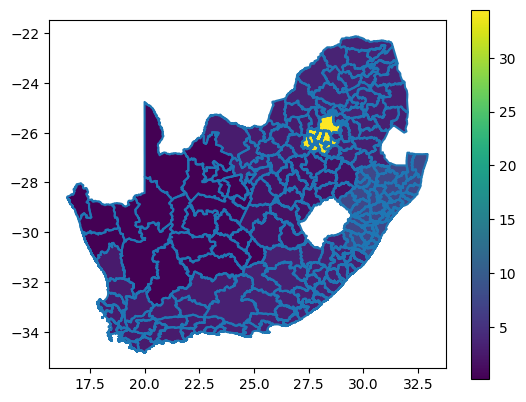

In [109]:
fig, ax = plt.subplots()
south_africa.boundary.plot(ax=ax)
south_africa.plot(ax=ax, column='pop_density', legend=True)
legend = ax.get_legend()
plt.show()

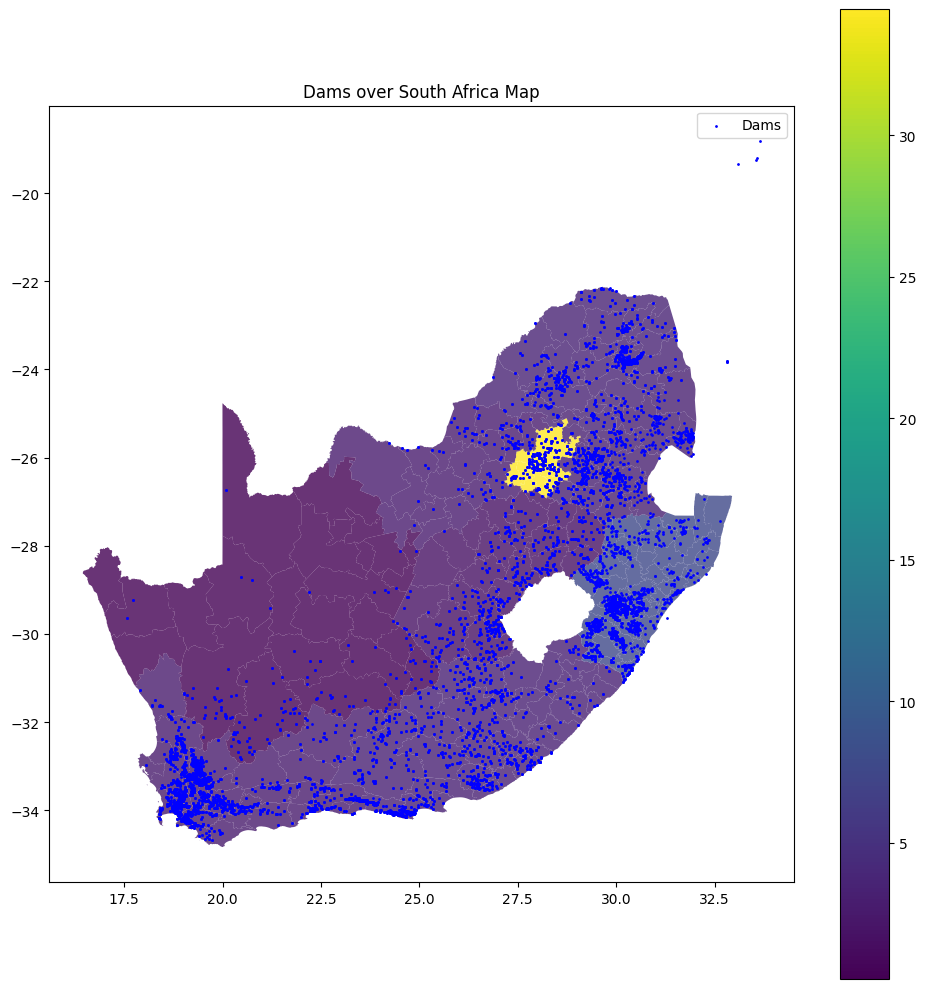

In [110]:
def dms_to_dd(deg, minutes, seconds):
    return deg + (minutes / 60) + (seconds / 3600)

dam_data['Latitude'] = dms_to_dd(dam_data['Latitude deg'], dam_data['Lat min'], dam_data['Lat sec'])
dam_data['Longitude'] = dms_to_dd(dam_data['Longitude deg'], dam_data['Long min'], dam_data['Long sec'])
dam_data['Latitude'] = -dam_data['Latitude'].abs()

dam_gdf = gpd.GeoDataFrame(
    dam_data,
    geometry=gpd.points_from_xy(dam_data['Longitude'], dam_data['Latitude']),
    crs="EPSG:4326"
)

fig, ax = plt.subplots(figsize=(10, 10))

# Plot population density with a color scale
south_africa.plot(
    ax=ax,
    column='pop_density',
    cmap='viridis',
    markersize=1,
    legend=True,
    alpha=0.8)

# Overlay dams
dam_gdf.plot(ax=ax, color='blue', markersize=1, label='Dams')

plt.title('Dams over South Africa Map')
plt.legend()
plt.tight_layout()
plt.show()

# Ethiopia

In [111]:
# Loading
## Import Ethiopia Map
ethiopia = gpd.read_file(file_path + 'Ethiopia/Ethiopia_AdminBoundaries.shp')

## Load roads
eth_roads = gpd.read_file(file_path + 'Ethiopia/Ethiopia_Roads.shp')

## Load energy transmission
eth_transmission = gpd.read_file(file_path + 'Ethiopia/Ethiopia Electricity Transmission Network.shp')

## Load population
eth_pop = pd.read_csv(file_path + 'Ethiopia/eth_admpop_adm3_2022_v2.csv')

eth_pop['admin1Name_en'].unique()

/usr/local/lib/python3.11/dist-packages/pyogrio/raw.py:198: UserWarning: Measured (M) geometry types are not supported. Original type 'Measured LineString' is converted to 'LineString'
  return ogr_read(


array(['Tigray', 'Afar', 'Amhara', 'Oromia', 'Somali', 'Benishangul Gumz',
       'SNNP', 'South West Ethiopia', 'Gambela', 'Harari', 'Addis Ababa',
       'Dire Dawa', 'Sidama'], dtype=object)

In [112]:
# Ethiopia population density calculation

ethiopia_regions_area_km2 = {
    "Addis Ababa": 527,
    "Afar": 96_707,
    "Amhara": 154_709,
    "Benishangul Gumz": 50_380,
    "Dire Dawa": 1_213,
    "Gambela": 29_782,
    "Harari": 334,
    "Oromia": 353_632,
    "Somali": 279_252,
    "Sidama": 10_000,
    "SNNP": 108_386,
    "South West Ethiopia": 39_400,
    "Tigray": 50_079
}

eth_population_by_province = eth_pop.groupby('admin1Name_en')['T_TL'].sum().reset_index()

eth_population_by_province['area_km2'] = eth_population_by_province['admin1Name_en'].map(ethiopia_regions_area_km2)
eth_population_by_province['pop_density'] = eth_population_by_province['T_TL'] / eth_population_by_province['area_km2']
eth_population_by_province

,admin1Name_en,T_TL,area_km2,pop_density
0,Addis Ababa,3773999,527,7161.288425
1,Afar,1989996,96707,20.577580
2,Amhara,22530516,154709,145.631579
3,Benishangul Gumz,1187997,50380,23.580726
4,Dire Dawa,520998,1213,429.511954
5,Gambela,492002,29782,16.520113
6,Harari,270001,334,808.386228
7,Oromia,39075002,353632,110.496228
8,SNNP,13250643,108386,122.254193
9,Sidama,3987456,10000,398.745600


In [113]:
ethiopia['REGIONNAME'].unique()

array(['Addis Ababa', 'Tigray', 'Somali', 'Dire Dawa', 'Hareri',
       'Gambela', 'Beneshangul Gumu', 'Amhara', 'Afar', 'Oromia', 'SNNPR'],
      dtype=object)

In [114]:
# Align Region Names across dataframes
eth_region_names = {
    'Benishangul Gumz': 'Benishangul Gumu',
    'Hareri': 'Harari',
    'SNNP': 'SNNPR'
}

eth_population_by_province['REGIONNAME'] = eth_population_by_province['admin1Name_en'].replace(eth_region_names)
eth_population_by_province

,admin1Name_en,T_TL,area_km2,pop_density,REGIONNAME
0,Addis Ababa,3773999,527,7161.288425,Addis Ababa
1,Afar,1989996,96707,20.577580,Afar
2,Amhara,22530516,154709,145.631579,Amhara
3,Benishangul Gumz,1187997,50380,23.580726,Benishangul Gumu
4,Dire Dawa,520998,1213,429.511954,Dire Dawa
5,Gambela,492002,29782,16.520113,Gambela
6,Harari,270001,334,808.386228,Harari
7,Oromia,39075002,353632,110.496228,Oromia
8,SNNP,13250643,108386,122.254193,SNNPR
9,Sidama,3987456,10000,398.745600,Sidama


In [115]:
# Merge population density and Ethiopia Geodataframe
ethiopia = ethiopia.merge(eth_population_by_province, on='REGIONNAME')
ethiopia

,OBJECTID,REGIONNAME,ZONENAME,WOREDANO_,WOREDANAME,GlobalID,Shape__Are,Shape__Len,geometry,admin1Name_en,T_TL,area_km2,pop_density
0,1,Addis Ababa,Region 14,140102,Nefas Silk,695a39eb-38a2-4680-82e3-c34d7559ee45,6.019472e+07,42074.127942,"MULTIPOLYGON (((38.70186 8.92537, 38.70185 8.9...",Addis Ababa,3773999,527,7161.288425
1,2,Addis Ababa,Region 14,140104,Bole,d21bf315-15e2-40eb-9a55-92e102600a0f,1.317679e+08,57202.004332,"POLYGON ((38.89908 8.95556, 38.89754 8.95547, ...",Addis Ababa,3773999,527,7161.288425
2,3,Addis Ababa,Region 14,140105,Lideta,7f82355a-ed21-48bd-9d49-2e3cb58b824b,1.134951e+07,20053.075002,"POLYGON ((38.75398 9.01721, 38.75398 9.01718, ...",Addis Ababa,3773999,527,7161.288425
3,4,Addis Ababa,Region 14,140106,Kirkos,deb15e6d-331b-433e-bdb8-cd5dfca4bb79,1.512233e+07,19354.492903,"POLYGON ((38.76493 9.02229, 38.76499 9.02216, ...",Addis Ababa,3773999,527,7161.288425
4,5,Addis Ababa,Region 14,140107,Yeka,1f7e0179-f18e-43c1-9838-9ad28d2a6e1a,8.901921e+07,47690.016803,"POLYGON ((38.89684 9.02942, 38.89097 9.02327, ...",Addis Ababa,3773999,527,7161.288425
...,...,...,...,...,...,...,...,...,...,...,...,...,...
657,680,SNNPR,Gurage,070109,Gumer,823c7b7c-ab26-4255-b459-d4ea57fdffc8,2.042026e+08,67203.178529,"POLYGON ((38.0664 7.89435, 38.06031 7.88358, 3...",SNNP,13250643,108386,122.254193
658,681,SNNPR,Segen Peoples',None,Alle,f689ede0-c182-4331-aa83-cdb26c99382e,1.065196e+09,183068.475861,"POLYGON ((37.12637 5.72452, 37.12725 5.72444, ...",SNNP,13250643,108386,122.254193
659,682,SNNPR,Segen Peoples',071601,Derashe,9e03bdc6-a6b3-41f4-a48e-7b95682fb9b3,7.265555e+08,179539.187123,"POLYGON ((37.56279 5.71065, 37.56576 5.69569, ...",SNNP,13250643,108386,122.254193
660,683,SNNPR,Gamo Gofa,071012,Kemba,d269c6a4-ba68-4f20-b6cd-4f9a70f03bc9,1.264534e+09,186707.754503,"POLYGON ((37.2945 5.98755, 37.28325 5.98294, 3...",SNNP,13250643,108386,122.254193


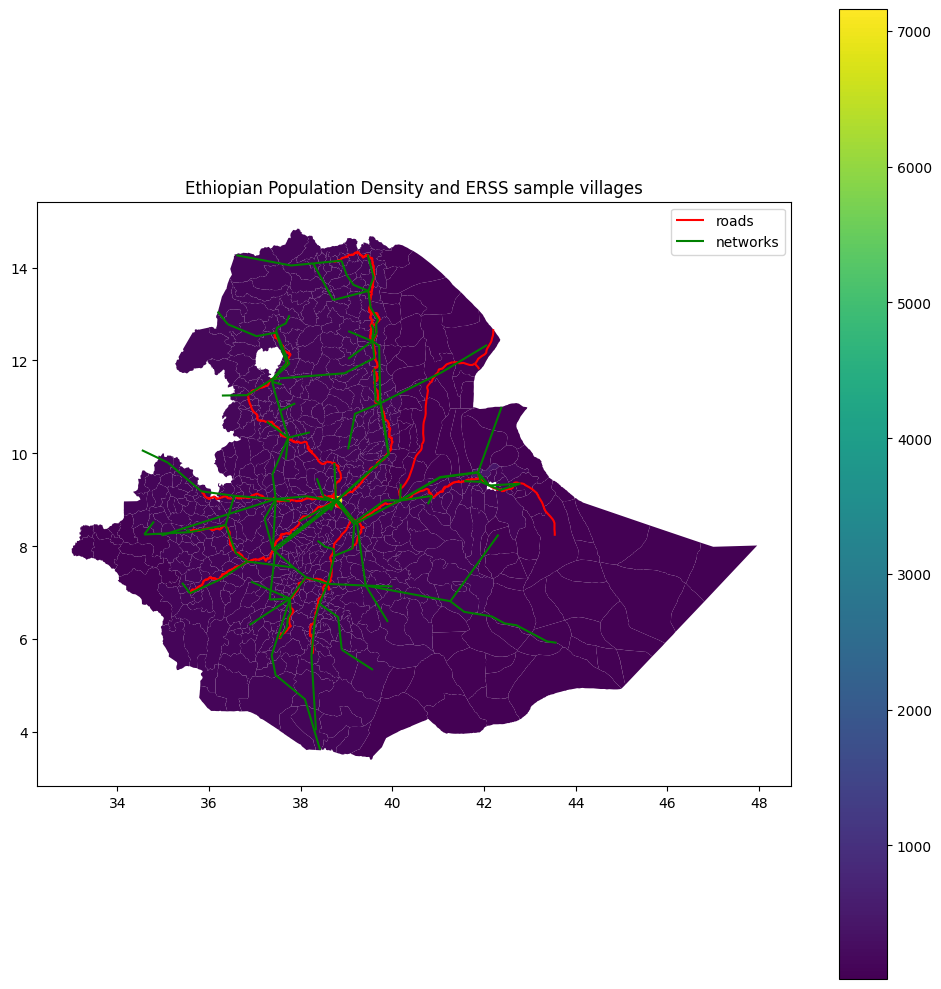

In [117]:
fig, ax = plt.subplots(figsize=(10, 10))

# Overlay roads
eth_roads.plot(ax=ax, color='red', markersize=1, label='roads')
# Overlay networks
eth_transmission.plot(ax=ax, color='green', markersize=1, label='networks')
# Overlay density
ethiopia.plot(ax=ax, column='pop_density', legend=True)

plt.title('Ethiopian Population Density and ERSS sample villages')
plt.legend()
plt.tight_layout()
plt.show()

# Vietnam

<Axes: >

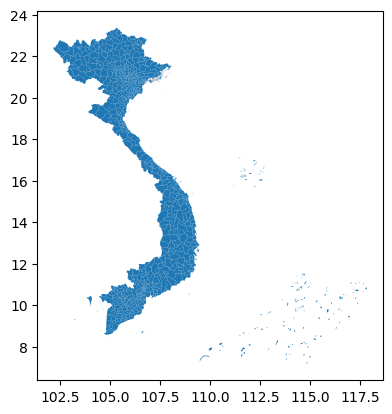

In [118]:
# Import Vietnam shape
vietnam = gpd.read_file(file_path + 'Vietnam/vnm_admbnda_adm2_gov_20201027.shp')
vietnam.plot()

<Axes: >

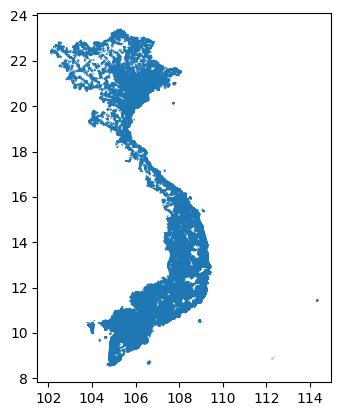

In [119]:
# Import road data
v_roads = gpd.read_file(file_path + 'Vietnam/gis_osm_roads_free_1.shp')
v_roads.plot()

In [76]:
v_roads['fclass'].unique()

array(['footway', 'residential', 'primary', 'tertiary', 'primary_link',
       'secondary', 'trunk', 'service', 'motorway', 'motorway_link',
       'unclassified', 'secondary_link', 'path', 'pedestrian',
       'tertiary_link', 'track', 'steps', 'trunk_link', 'cycleway',
       'living_street', 'track_grade1', 'track_grade5', 'track_grade4',
       'track_grade3', 'unknown', 'track_grade2', 'busway', 'bridleway'],
      dtype=object)

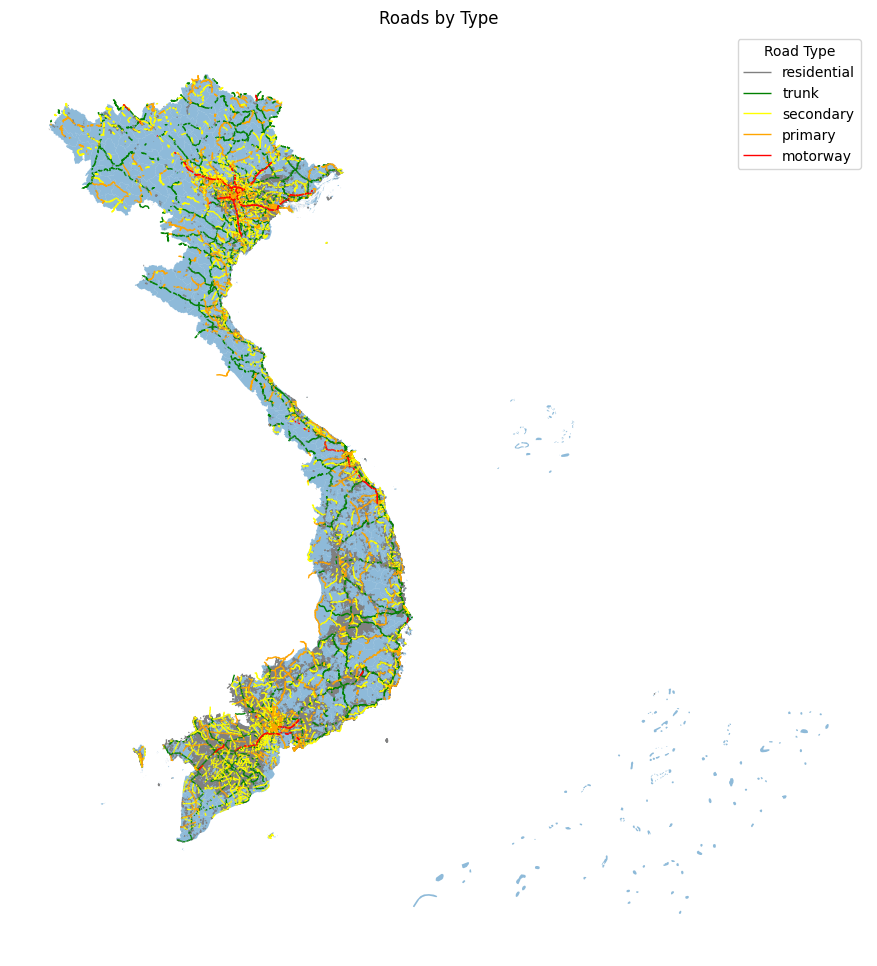

In [120]:
fig, ax = plt.subplots(figsize=(12, 12))

# Plot map
vietnam.plot(ax=ax, alpha=0.5)

# Overlay roads
## Selects major road types
types_colors = {
    'residential': 'gray',
    'trunk': 'green',
    'secondary': 'yellow',
    'primary': 'orange',
    'motorway': 'red'
}

for rtype, color in types_colors.items():
    v_roads[v_roads['fclass'] == rtype].plot(ax=ax, color=color, label=rtype, linewidth=1)

plt.legend(title="Road Type")
plt.title("Roads by Type")
plt.axis('off')
plt.show()

In [121]:
v_roads['fclass']

,fclass
0,footway
1,residential
2,primary
3,tertiary
4,residential
...,...
3047037,service
3047038,service
3047039,tertiary
3047040,service


# Brazil

In [122]:
brazil = gpd.read_file(file_path + 'Brazil/outline_mainland_only_prj.shp')
b_roads = gpd.read_file(file_path + 'Brazil/highways_2010_prj.shp')
b_cities = gpd.read_file(file_path + 'Brazil/brazil_capital_cities_prj.shp')

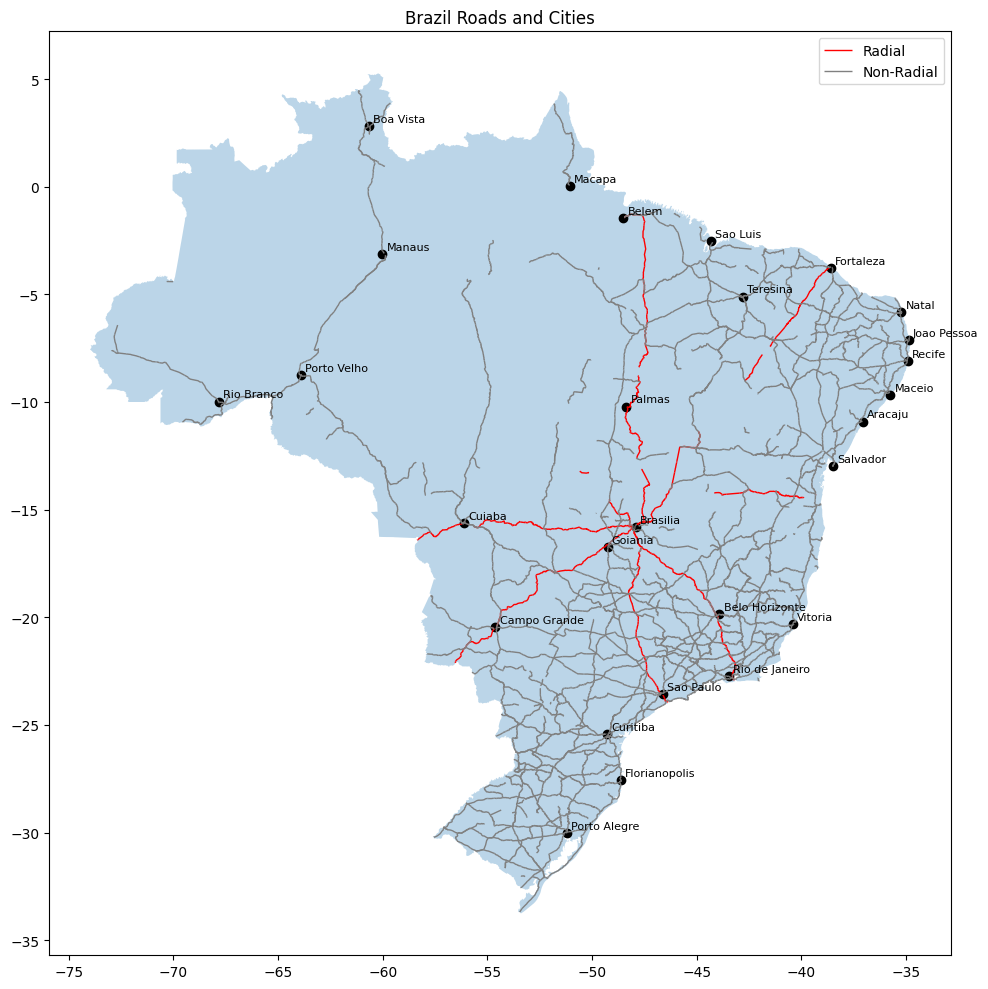

In [123]:
fig, ax = plt.subplots(figsize=(10, 10))

# Plot Brazil map
brazil.plot(ax=ax, alpha=0.3)
from matplotlib.lines import Line2D

# Setting up radial road distinction
b_roads[b_roads['dm_radial'] == 1].plot(ax=ax, color='red', linewidth=1, label='Radial')
b_roads[b_roads['dm_radial'] == 0].plot(ax=ax, color='gray', linewidth=1, label='Non-Radial')

# Manual legend
legend_elements = [
    Line2D([0], [0], color='red', lw=2, label='Radial'),
    Line2D([0], [0], color='gray', lw=2, label='Non-Radial')
]
ax.legend(handles=legend_elements, title="Road Type")

# Overlay cities
b_cities.plot(ax=ax, color='black')

for idx, row in b_cities.iterrows():
    ax.annotate(row['CITY_NAME'], xy=(row.geometry.x, row.geometry.y),
                xytext=(3, 3), textcoords="offset points", fontsize=8)

plt.title('Brazil Roads and Cities')
plt.legend()
plt.tight_layout()
plt.show()